In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random
from jax import grad, vmap, pmap, jit
from functools import partial
import pickle

%config IPCompleter.use_jedi = False

In [3]:
def train_validation_split(X, y, ratio):
    dataset_size = len(X)
    label_size = len(y)
    assert dataset_size == label_size
    assert ratio <= 1 and ratio > 0
    validation_size = int(ratio * dataset_size)

    random_indicies = np.random.RandomState(seed=513).permutation(dataset_size)

    train_X = X[random_indicies][:dataset_size - validation_size]
    train_y = y[random_indicies][:dataset_size - validation_size]
    validation_X = X[random_indicies][dataset_size - validation_size:]
    validation_y = y[random_indicies][dataset_size - validation_size:]

    return train_X, train_y, validation_X, validation_y

In [4]:
def downloading(path, source='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'):
    if sys.version_info[0] == 2:
        from urllib import urlopen
    else:
        from urllib.request import urlopen
    
    import tarfile
    if not os.path.exists(path):
        os.makedirs(path)
    u = urlopen(source)
    with tarfile.open(fileobj=u, mode='r|gz') as f:
        f.extractall(path=path)
    u.close()

def loading(path):
    downloading(path)

    train_data = [pickle.load(open(os.path.join(path, 'cifar-10-batches-py', 'data_batch_%d' % (i + 1)), 'rb'),
                              encoding='latin1') for i in range(5)]

    X_train = np.vstack([d['data'] for d in train_data])
    y_train = np.hstack([np.asarray(d['labels'], np.int8) for d in train_data])

    test_data = pickle.load(open(os.path.join(path, 'cifar-10-batches-py', 'test_batch'), 'rb'), encoding='latin1')
    X_test = test_data['data']
    y_test = np.asarray(test_data['labels'], np.int8)

    X_train = X_train.reshape(-1, 3, 32, 32)
    X_train = X_train.transpose(0,2,3,1)
    X_test = X_test.reshape(-1, 3, 32, 32)
    X_test = X_test.transpose(0,2,3,1)

    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = loading('.')

In [6]:
X_train.shape

(50000, 32, 32, 3)

In [7]:
X_train_scaled = jnp.array(X_train / 255.)
X_test_scaled = jnp.array(X_test / 255.)
y_train_hot = jnp.squeeze(jax.nn.one_hot(y_train, num_classes=10))
y_valid_hot = jnp.squeeze(jax.nn.one_hot(y_test, num_classes=10))

In [8]:
X_train_standardized =\
  jax.nn.standardize(x = X_train_scaled,
                     mean = jnp.array([0.4914, 0.4822, 0.4465]),
                     variance = jnp.array([0.2023**2, 0.1994**2, 0.2010**2]))
X_test_standardized = \
  jax.nn.standardize(x = X_test_scaled,
                     mean = jnp.array([0.4914, 0.4822, 0.4465]),
                     variance = jnp.array([0.2023**2, 0.1994**2, 0.2010**2]))

In [9]:
train_X, train_y, valid_X, valid_y = train_validation_split(X_train_standardized, y_train, 0.2)

In [10]:
label_dict = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

In [11]:
def identity(x):
    return x


def rotation(x, prob):
    return jax.lax.cond(prob, jnp.rot90, identity, x)


def horizontal_flip(x, prob):
    return jax.lax.cond(prob, jnp.fliplr, identity, x)
    
    
def vertical_flip(x, prob):
    return jax.lax.cond(prob, jnp.flipud, identity, x)


def pighead(x):
    r_start = random.randint(key=random.PRNGKey(1126), shape=(1,), minval=0, maxval=7)[0]
    c_start = random.randint(key=random.PRNGKey(1126), shape=(1,), minval=0, maxval=7)[0]
    x = jnp.pad(x, pad_width = np.array([[4, 4], [4, 4], [0, 0]]),\
                mode = "constant", constant_values=np.array([[0.4914], [0.4822], [0.4465]]))
    return jax.lax.dynamic_slice(x, (r_start, c_start, 0), (32, 32, 3))


def jigsaw(x, prob):
    return jax.lax.cond(prob, pighead, identity, x)



In [12]:
rotation_jit = jit(vmap(rotation, in_axes=(0, 0)))
horizontal_flip_jit = jit(vmap(horizontal_flip, in_axes=(0, 0)))
vertocal_flip_jit = jit(vmap(vertical_flip, in_axes=(0, 0)))
jigsaw_jit = jit(vmap(jigsaw, in_axes=(0, 0)))


# Tun the four p's in bernoulli
def contamination_factory(X, key):
    batch_size = len(X)
    
    key, _ = random.split(key)
    prob = random.bernoulli(key=key, p=0.3, shape=[batch_size])
    X = jigsaw_jit(X, prob)

    key, _ = random.split(key)
    prob = random.bernoulli(key=key, p=0.3, shape=[batch_size])
    X = rotation_jit(X, prob)
    
    key, _ = random.split(key)
    prob = random.bernoulli(key=key, p=0.3, shape=[batch_size])
    X = horizontal_flip_jit(X, prob)
    
    key, _ = random.split(key)
    prob = random.bernoulli(key=key, p=0.3, shape=[batch_size])
    X = vertocal_flip_jit(X, prob)

    return X

In [17]:
def plot_samples(X, y, num_rows, num_columns, figsize=(12, 8), title=None):
    # Need to un-standardize X to clip pixel values to [0.0, 1.0]
    X = X * jnp.array([0.2023, 0.1994, 0.2010]) + jnp.array([0.4914, 0.4822, 0.4465])

    _, ax = plt.subplots(num_rows, num_columns, figsize=figsize)
    for i in range(num_rows * num_columns):
        img = X[i]
        label = str(y[i])
        ax[i // num_columns, i % num_columns].imshow(img.reshape(32, 32, 3))
        ax[i // num_columns, i % num_columns].set_title(label)
        ax[i // num_columns, i % num_columns].axis("off")

    if title:
        plt.suptitle(str(title))
    plt.show()

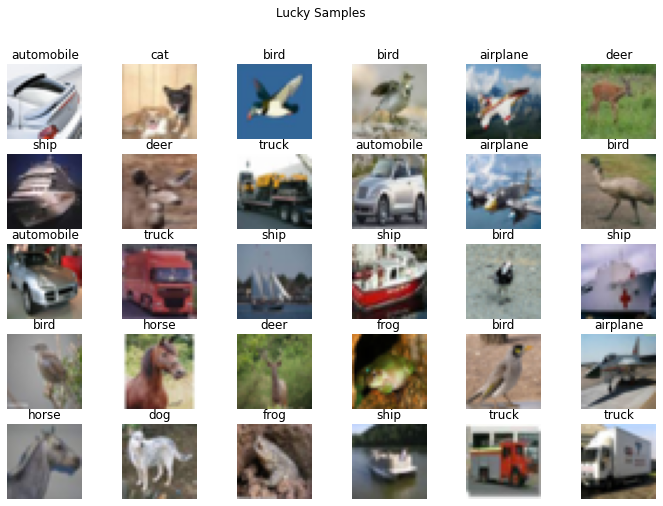

In [18]:
sample_size = 30
indices = np.arange(len(train_X))
random_idx = np.random.choice(indices, size=(sample_size))

sample_X = train_X[random_idx]
sample_y = train_y[random_idx]

sample_label_dict = [label_dict.get(i) for i in sample_y]

plot_samples(
    X=sample_X,
    y=sample_label_dict,
    num_rows = 5, num_columns = 6,
    title = "Lucky Samples"
)

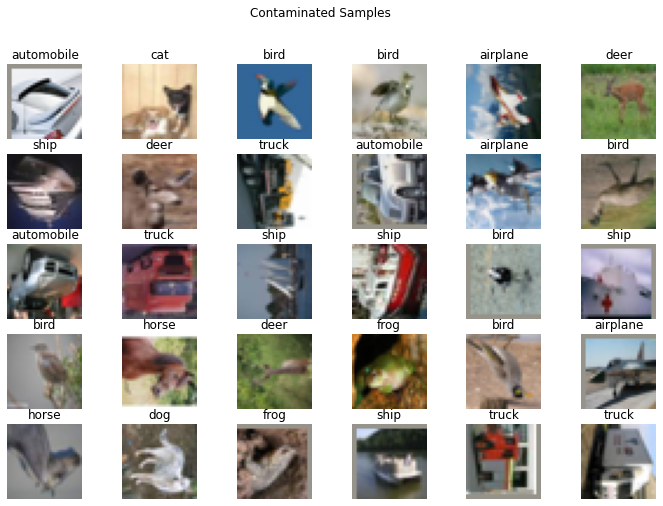

In [19]:
sample_X_contaminated = contamination_factory(
    sample_X, key=random.PRNGKey(0)
)

plot_samples(
    X=sample_X_contaminated,
    y=sample_label_dict,
    num_rows = 5, num_columns = 6,
    title = "Contaminated Samples"
)

In [16]:
# If shuffle == True, then the original arrays would be shuffled as well.
# So if you want to keep the original ones, please make the copies before
# passing them to this function
def yield_batches(X, y, batch_size, shuffle=False,
                  contamination = True, key = 1126):
    assert len(X) == len(y)
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]
    
    for i in range(0, len(X) - batch_size + 1, batch_size):
        batch_indices = slice(i, i + batch_size)

        if contamination:
            yield contamination_factory(X[batch_indices], key = random.PRNGKey(key)), y[batch_indices]
        else:
            yield X[batch_indices], y[batch_indices]